# Recommender Systems with Python

Welcome to the code notebook for Recommender Systems with Python. 
In this notebook, we will focus on providing a recommendation system by suggesting items that are most similar to a particular item, in this case, movies. Keep in mind, this is not a true robust recommendation system, to describe it more accurately,it just tells you what movies/items are most similar to your movie choice.

Let's get started!

## Import Libraries

In [1]:
import numpy as np
import pandas as pd

## Get the Data

In [2]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)

In [3]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [4]:
df.shape

(100003, 4)

Now let's get the movie titles:

In [5]:
movie_titles = pd.read_csv("Movie_Id_Titles")
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


We can merge them together:

In [6]:
df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


# EDA

Let's explore the data a bit and get a look at some of the best rated movies.

## Visualization Imports

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

Let's create a ratings dataframe with average rating and number of ratings:

In [8]:
df.groupby('title')['rating'].mean().sort_values(ascending=False)

title
Marlene Dietrich: Shadow and Light (1996)       5.0
Prefontaine (1997)                              5.0
Santa with Muscles (1996)                       5.0
Star Kid (1997)                                 5.0
Someone Else's America (1995)                   5.0
                                               ... 
Touki Bouki (Journey of the Hyena) (1973)       1.0
JLG/JLG - autoportrait de décembre (1994)       1.0
Daens (1992)                                    1.0
Butterfly Kiss (1995)                           1.0
Eye of Vichy, The (Oeil de Vichy, L') (1993)    1.0
Name: rating, Length: 1664, dtype: float64

In [9]:
df.groupby('title')['rating'].count().sort_values(ascending=False)

title
Star Wars (1977)                              584
Contact (1997)                                509
Fargo (1996)                                  508
Return of the Jedi (1983)                     507
Liar Liar (1997)                              485
                                             ... 
Man from Down Under, The (1943)                 1
Marlene Dietrich: Shadow and Light (1996)       1
Mat' i syn (1997)                               1
Mille bolle blu (1993)                          1
Á köldum klaka (Cold Fever) (1994)              1
Name: rating, Length: 1664, dtype: int64

In [10]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390
...,...
Young Guns II (1990),2.772727
"Young Poisoner's Handbook, The (1995)",3.341463
Zeus and Roxanne (1997),2.166667


Now set the number of ratings column:

In [11]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41
...,...,...
Young Guns II (1990),2.772727,44
"Young Poisoner's Handbook, The (1995)",3.341463,41
Zeus and Roxanne (1997),2.166667,6


Now a few histograms:

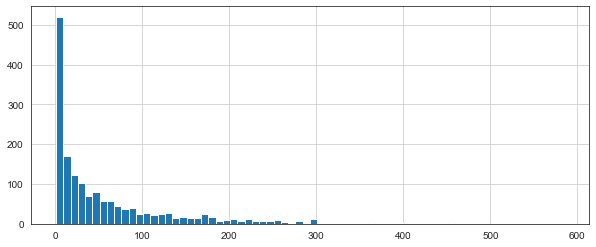

In [12]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

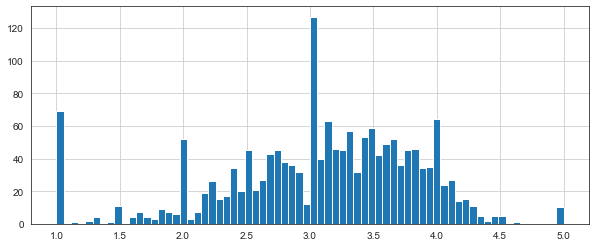

In [13]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

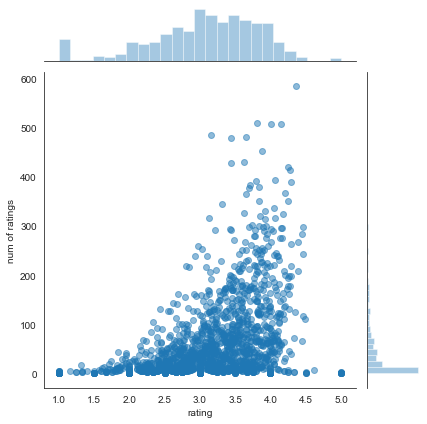

In [14]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)

Okay! Now that we have a general idea of what the data looks like, let's move on to creating a simple recommendation system:

## Recommending Similar Movies

Now let's create a matrix that has the user ids on one access and the movie title on another axis. Each cell will then consist of the rating the user gave to that movie. Note there will be a lot of NaN values, because most people have not seen most of the movies.

In [15]:
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [16]:
pd.set_option("display.max_rows",2000)
pd.set_option("display.max_columns",2000)

In [17]:
df[df["user_id"]==1]

,user_id,item_id,rating,timestamp,title
257,1,50,5,874965954,Star Wars (1977)
926,1,172,5,874965478,"Empire Strikes Back, The (1980)"
999,1,133,4,876892818,Gone with the Wind (1939)
1138,1,242,5,889751633,Kolya (1996)
1557,1,51,4,878543275,Legends of the Fall (1994)
1956,1,265,4,878542441,"Hunt for Red October, The (1990)"
2460,1,86,5,878543541,"Remains of the Day, The (1993)"
2697,1,257,4,874965954,Men in Black (1997)
2992,1,222,4,878873388,Star Trek: First Contact (1996)
3369,1,40,3,876893230,"To Wong Foo, Thanks for Everything! Julie Newm..."


In [18]:
moviemat = df.pivot_table(index='user_id',columns='title',values='rating')
moviemat.head()

title    'Til There Was You (1997)  1-900 (1994)  101 Dalmatians (1996)  \
user_id                                                                   
0                              NaN           NaN                    NaN   
1                              NaN           NaN                    2.0   
2                              NaN           NaN                    NaN   
3                              NaN           NaN                    NaN   
4                              NaN           NaN                    NaN   

title    12 Angry Men (1957)  187 (1997)  2 Days in the Valley (1996)  \
user_id                                                                 
0                        NaN         NaN                          NaN   
1                        5.0         NaN                          NaN   
2                        NaN         NaN                          NaN   
3                        NaN         2.0                          NaN   
4                        NaN         NaN                          NaN   

title    20,000 Leagues Under the Sea (1954)  2001: A Space Odyssey (1968)  \
user_id                                                                      
0                                        NaN                           NaN   
1                                        3.0                           4.0   
2                                        NaN                           NaN   
3                                        NaN                           NaN   
4                                        NaN                           NaN   

title    3 Ninjas: High Noon At Mega Mountain (1998)  39 Steps, The (1935)  \
user_id                                                                      
0                                                NaN                   NaN   
1                                                NaN                   NaN   
2                                                1.0                   NaN   
3                                                NaN                   NaN   
4                                                NaN                   NaN   

title    8 1/2 (1963)  8 Heads in a Duffel Bag (1997)  8 Seconds (1994)  \
user_id                                                                   
0                 NaN                             NaN               NaN   
1                 NaN                             NaN               NaN   
2                 NaN                             NaN               NaN   
3                 NaN                             NaN               NaN   
4                 NaN                             NaN               NaN   

title    A Chef in Love (1996)  Above the Rim (1994)  Absolute Power (1997)  \
user_id                                                                       
0                          NaN                   NaN                    NaN   
1                          NaN                   NaN                    NaN   
2                          NaN                   NaN                    3.0   
3                          NaN                   NaN                    NaN   
4                          NaN                   NaN                    NaN   

title    Abyss, The (1989)  Ace Ventura: Pet Detective (1994)  \
user_id                                                         
0                      NaN                                NaN   
1                      3.0                                3.0   
2                      NaN                                NaN   
3                      NaN                                NaN   
4                      NaN                                NaN   

title    Ace Ventura: When Nature Calls (1995)  Across the Sea of Time (1995)  \
user_id                                                                         
0                                          NaN                            NaN   
1                                          NaN                            NaN   
2       

Most rated movie:

In [19]:
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


Let's choose two movies: starwars, a sci-fi movie. And Liar Liar, a comedy.

In [20]:
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Now let's grab the user ratings for those two movies:

In [21]:
starwars_user_ratings = moviemat['Star Wars (1977)']
starwars_user_ratings

user_id
0      5.0
1      5.0
2      5.0
3      NaN
4      5.0
5      4.0
6      4.0
7      5.0
8      5.0
9      5.0
10     5.0
11     NaN
12     4.0
13     5.0
14     5.0
15     5.0
16     NaN
17     NaN
18     4.0
19     NaN
20     3.0
21     3.0
22     5.0
23     4.0
24     NaN
25     5.0
26     4.0
27     3.0
28     4.0
29     NaN
30     3.0
31     NaN
32     4.0
33     NaN
34     NaN
35     NaN
36     NaN
37     5.0
38     NaN
39     NaN
40     NaN
41     5.0
42     5.0
43     4.0
44     5.0
45     5.0
46     4.0
47     NaN
48     4.0
49     1.0
50     NaN
51     5.0
52     NaN
53     4.0
54     5.0
55     4.0
56     5.0
57     5.0
58     4.0
59     5.0
60     5.0
61     NaN
62     5.0
63     4.0
64     5.0
65     5.0
66     5.0
67     NaN
68     5.0
69     5.0
70     4.0
71     3.0
72     2.0
73     NaN
74     NaN
75     NaN
76     NaN
77     4.0
78     NaN
79     4.0
80     3.0
81     NaN
82     5.0
83     3.0
84     NaN
85     5.0
86     NaN
87     5.0
88     NaN
89     5.0
90

In [22]:
liarliar_user_ratings = moviemat['Liar Liar (1997)']
liarliar_user_ratings.head()

user_id
0    NaN
1    NaN
2    1.0
3    2.0
4    5.0
Name: Liar Liar (1997), dtype: float64

We can then use corrwith() method to get correlations between two pandas series:

In [23]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_starwars

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


title
'Til There Was You (1997)                                                            8.728716e-01
1-900 (1994)                                                                        -6.454972e-01
101 Dalmatians (1996)                                                                2.111323e-01
12 Angry Men (1957)                                                                  1.842894e-01
187 (1997)                                                                           2.739782e-02
2 Days in the Valley (1996)                                                          6.665413e-02
20,000 Leagues Under the Sea (1954)                                                  2.897683e-01
2001: A Space Odyssey (1968)                                                         2.308841e-01
3 Ninjas: High Noon At Mega Mountain (1998)                                                   NaN
39 Steps, The (1935)                                                                 1.064529e-01
8 1/2 (1963)  

In [24]:
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)
similar_to_liarliar

title
'Til There Was You (1997)                                                            1.189129e-01
1-900 (1994)                                                                                  NaN
101 Dalmatians (1996)                                                                4.697649e-01
12 Angry Men (1957)                                                                  6.627186e-02
187 (1997)                                                                           1.751446e-01
2 Days in the Valley (1996)                                                          4.073891e-02
20,000 Leagues Under the Sea (1954)                                                 -2.793201e-02
2001: A Space Odyssey (1968)                                                        -5.786430e-02
3 Ninjas: High Noon At Mega Mountain (1998)                                                   NaN
39 Steps, The (1935)                                                                 4.009182e-01
8 1/2 (1963)  

Let's clean this by removing NaN values and using a DataFrame instead of a series:

In [25]:
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


Now if we sort the dataframe by correlation, we should get the most similar movies, however note that we get some results that don't really make sense. This is because there are a lot of movies only watched once by users who also watched star wars (it was the most popular movie). 

In [26]:
corr_starwars.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0
Hollow Reed (1996),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Good Man in Africa, A (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based off the histogram from earlier).

In [27]:
corr_starwars = corr_starwars.join(ratings['num of ratings'])
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


Now sort the values and notice how the titles make a lot more sense:

In [28]:
corr_starwars[corr_starwars['num of ratings']>100].sort_values('Correlation',ascending=False).head(10)

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
Pinocchio (1940),0.347868,101
"Frighteners, The (1996)",0.332729,115


Now the same for the comedy Liar Liar:

In [29]:
corr_liarliar = pd.DataFrame(similar_to_liarliar,columns=['Correlation'])
corr_liarliar.dropna(inplace=True)
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])
corr_liarliar[corr_liarliar['num of ratings']>100].sort_values('Correlation',ascending=False).head(10)

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137
Pretty Woman (1990),0.469790,164
101 Dalmatians (1996),0.469765,109
Michael (1996),0.442022,119
Waterworld (1995),0.438405,102
